In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [2]:
dmeeting = pd.read_parquet('./data/data_meeting.parquet')
data_agenda1 = pd.read_parquet('./data/data_agenda1.parquet')
data_agenda2 = pd.read_parquet('./data/data_agenda2.parquet')
data_agenda3 = pd.read_parquet('./data/data_agenda3.parquet')
data_speech1 = pd.read_parquet('./data/data_speech1.parquet')
data_speech2 = pd.read_parquet('./data/data_speech2.parquet')
data_speech3 = pd.read_parquet('./data/data_speech3.parquet')
parMem = pd.read_parquet('./data/parliament_members.parquet')

dagenda = pd.concat([data_agenda1, data_agenda2, data_agenda3], axis=0)
dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)

annotation_data = pd.read_csv('data/annotation_data.csv')

## sample speech items from C and NC annotation data

In [3]:
annotation_data['label'].value_counts()

label
NC    1438
C      104
Name: count, dtype: int64

In [4]:
agendaC = annotation_data[annotation_data['label'] == 'C']
speechC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechC['label'] = 'C'
print(len(speechC))

2271


C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4248982907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speechC['label'] = 'C'


In [5]:
agendaNC = annotation_data[annotation_data['label'] == 'NC']
speechNC = dspeech[dspeech[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(agendaNC[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
speechNC = pd.merge(speechNC, agendaNC[['meeting_id', 'agenda_item_id', 'group']], on=['meeting_id', 'agenda_item_id'], how='left')
speechNC['label'] = 'NC'

We have 2271 speech items from agenda items annotated 'C'. Next we sample ~2271 speech items from agenda items annotated 'NC' with respect to year and type, using stratified-k-fold.

In [6]:
from sklearn.model_selection import StratifiedKFold

X = [0] * len(speechNC)
nsplits = int(1/(len(speechC)/len(speechNC)))

stratified_kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(stratified_kfold.split(X, speechNC.group.to_list())):
    val_index = list(val_idx)
    speechNC = speechNC.loc[val_index]
    break

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=15.
  warnings.warn(


In [7]:
speechNC = speechNC.drop(columns = 'group')

In [8]:
speech_comb = pd.concat([speechC, speechNC])
speech_comb = speech_comb.rename(columns={'label': 'label_agenda'})

In [9]:
speech_comb

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label_agenda
4113,22,16,2,15:28:48,15:29:06,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,Spørgsmålet lyder: Vil ministeren i statsminis...,18.0,44,C
4114,22,16,4,15:29:10,15:30:28,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Tak for spørgsmålet. Lad mig starte med at slå...,78.0,201,C
4115,22,16,6,15:30:30,15:31:36,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Er virkeligheden ikke, at kloden har behov for...",66.0,180,C
4116,22,16,8,15:31:39,15:33:10,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Nu kan det selvfølgelig være vanskeligt at fil...,91.0,327,C
4117,22,16,10,15:33:12,15:34:07,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Jamen virkeligheden er, at man jo netop ikke g...",55.0,191,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35328,1782,17,34,19:17:18,19:17:59,Torsten Schack Pedersen,V,medlem,Torsten Schack Pedersen(V):,"Jeg ved overhovedet ikke, hvad det er for en s...",41.0,139,NC
35366,1786,17,22,16:12:19,16:13:14,Jørn Dohrmann,DF,medlem,Jørn Dohrmann(DF):,"Jeg må bare sige til hr. Bjarne Laustsen, at v...",55.0,161,NC
35373,1786,17,36,16:17:30,16:17:45,Per Clausen,EL,medlem,Per Clausen(EL):,Jeg må prøve at gentage mit spørgsmål: Er det ...,15.0,48,NC
35386,1786,17,62,16:31:46,16:32:10,Bjarne Laustsen,S,medlem,Bjarne Laustsen(S):,Det er lidt i samme boldgade. Kan hr. Touborg ...,24.0,70,NC


### Preprocess text data for speech_comb

In [10]:
nlp = spacy.load("da_core_news_sm")
exception_list = ['CO2', 'co2']
def preprocess_text(text):
    doc = nlp(text)
    processed_tokens = [token.text.lower()for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens

def preprocess_text_lemma(text):
    doc = nlp(text)
    processed_tokens_lemma = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens_lemma 

In [11]:
speech_comb['processed_tokens'] = speech_comb.speech_item_text.apply(preprocess_text)
speech_comb['processed_tokens_lemma'] = speech_comb.speech_item_text.apply(preprocess_text_lemma)

In [12]:
speech_comb

,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,speech_item_text,duration,number_of_words,label_agenda,processed_tokens,processed_tokens_lemma
4113,22,16,2,15:28:48,15:29:06,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,Spørgsmålet lyder: Vil ministeren i statsminis...,18.0,44,C,"[spørgsmålet, lyder, ministeren, statsminister...","[spørgsmål, lyde, minister, statsminister, fra..."
4114,22,16,4,15:29:10,15:30:28,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Tak for spørgsmålet. Lad mig starte med at slå...,78.0,201,C,"[tak, spørgsmålet, starte, slå, fast, regering...","[tak, spørgsmål, starte, slå, fast, regering, ..."
4115,22,16,6,15:30:30,15:31:36,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Er virkeligheden ikke, at kloden har behov for...",66.0,180,C,"[virkeligheden, kloden, behov, initiativer, kl...","[virkelighed, klod, behov, initiativ, klimaomr..."
4116,22,16,8,15:31:39,15:33:10,Lykke Friis,V,minister,Klima- og energiministeren(Lykke Friis):,Nu kan det selvfølgelig være vanskeligt at fil...,91.0,327,C,"[selvfølgelig, vanskeligt, filosofere, hjælpe,...","[selvfølgelig, vanskelig, filosofere, hjælpe, ..."
4117,22,16,10,15:33:12,15:34:07,Mette Gjerskov,S,medlem,Mette Gjerskov(S):,"Jamen virkeligheden er, at man jo netop ikke g...",55.0,191,C,"[jamen, virkeligheden, netop, står, fast, eu, ...","[jamen, virkelighed, netop, stå, fast, eu, stå..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35328,1782,17,34,19:17:18,19:17:59,Torsten Schack Pedersen,V,medlem,Torsten Schack Pedersen(V):,"Jeg ved overhovedet ikke, hvad det er for en s...",41.0,139,NC,"[overhovedet, skattereform, socialdemokratiske...","[overhovedet, skattereform, socialdemokratisk,..."
35366,1786,17,22,16:12:19,16:13:14,Jørn Dohrmann,DF,medlem,Jørn Dohrmann(DF):,"Jeg må bare sige til hr. Bjarne Laustsen, at v...",55.0,161,NC,"[bare, bjarne, laustsen, gå, se, brede, forlig...","[bare, bjarne, laustsen, gå, se, bred, forlig,..."
35373,1786,17,36,16:17:30,16:17:45,Per Clausen,EL,medlem,Per Clausen(EL):,Jeg må prøve at gentage mit spørgsmål: Er det ...,15.0,48,NC,"[prøve, gentage, spørgsmål, korrekt, dansk, fo...","[prøve, gentage, spørgsmål, korrek, dansk, fol..."
35386,1786,17,62,16:31:46,16:32:10,Bjarne Laustsen,S,medlem,Bjarne Laustsen(S):,Det er lidt i samme boldgade. Kan hr. Touborg ...,24.0,70,NC,"[boldgade, touborg, erindre, dansk, folkeparti...","[boldgade, touborg, erindre, dansk, folkeparti..."


In [82]:
test_c1 = speech_comb.loc[speech_comb.label_agenda=="C"].processed_tokens.iloc[0]
test_c2 = speech_comb.loc[speech_comb.label_agenda=="C"].processed_tokens.iloc[1]
test_nc1 = speech_comb.loc[speech_comb.label_agenda=="NC"].processed_tokens.iloc[0]
test_nc2 = speech_comb.loc[speech_comb.label_agenda=="NC"].processed_tokens.iloc[1]

In [124]:
vec_list = []
for i in [test_c1, test_c2, test_nc1, test_nc2]:
    average_vec = np.zeros((500))
    for word in i:
        vec = model.word_vec(word)
        average_vec += vec/len(i)
    
    vec_list.append(average_vec)
        

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\3851782717.py:5: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vec = model.word_vec(word)


In [121]:
vec_list[0]

array([ 1.40942743e-02, -5.23389247e-03,  6.58046012e-03, -5.19009046e-02,
        2.57063552e-02,  2.19310858e-02, -4.05297565e-02, -2.45349728e-02,
        1.70964681e-01, -6.33346431e-02,  7.08872889e-02, -8.13947272e-02,
        8.66554867e-02,  1.16306203e-01, -5.19588331e-02,  1.22098861e-01,
       -1.08889899e-01, -7.02534204e-02,  1.51476594e-01,  1.60849810e-03,
        1.43392538e-01, -4.54350270e-02,  7.89708213e-02,  2.39598490e-02,
       -1.94229607e-01,  5.29386931e-02, -2.01540351e-01,  1.99998621e-03,
        5.96842768e-02, -1.07848895e-01,  7.26050523e-04,  2.29062618e-02,
        3.94680526e-03,  2.85120107e-02, -5.26244001e-03, -2.81945402e-02,
       -1.79080393e-01, -6.18640086e-02, -2.09763482e-02,  1.33024395e-02,
        9.33346603e-02, -8.93236614e-03,  8.64867766e-02,  1.05553193e-01,
       -1.51162031e-01, -2.28695786e-02,  4.86962970e-02,  6.41328430e-02,
        9.66313655e-02, -1.37820048e-02,  1.10849636e-01,  8.50248440e-02,
        1.71455100e-01,  

In [125]:
from numpy.linalg import norm
dot_product1 = np.dot(vec_list[0], vec_list[1])
dot_product2 = np.dot(vec_list[0], vec_list[3])
dot_product3 = np.dot(vec_list[1], vec_list[2])
dot_product4 = np.dot(vec_list[2], vec_list[3])


# Calculate the norm (magnitude) of each array
norm_0 = norm(vec_list[0])
norm_1 = norm(vec_list[1])
norm_2 = norm(vec_list[2])
norm_3 = norm(vec_list[3])

# Calculate the cosine similarity
cosine_similarity1 = dot_product1 / (norm_0 * norm_1)
cosine_similarity2 = dot_product2 / (norm_0 * norm_3)
cosine_similarity3 = dot_product3 / (norm_1 * norm_2)
cosine_similarity4 = dot_product4 / (norm_2 * norm_3)

print("Cosine Similarity:", cosine_similarity1)
print("Cosine Similarity:", cosine_similarity2)
print("Cosine Similarity:", cosine_similarity3)
print("Cosine Similarity:", cosine_similarity4)

Cosine Similarity: 0.8668551036297808
Cosine Similarity: 0.8390497885034142
Cosine Similarity: 0.8583750367672326
Cosine Similarity: 0.9156166359289916


### Unique words and odds

In [13]:
def caluc_proportion(numerator, denominator):
    if denominator == 0:
        if numerator == 0:
            return 0
        else:
            return numerator
    else:
        if numerator == 0:
            return 0
        else:
            return numerator/denominator

In [14]:
unique_words_list_C = []
unique_words_list_NC = []

for i in range(len(speech_comb[speech_comb['label_agenda']=='C'])):
    unique_words_list_C.extend(speech_comb[speech_comb['label_agenda']=='C'].processed_tokens_lemma.iloc[i])
for i in range(len(speech_comb[speech_comb['label_agenda']=='NC'])):
    unique_words_list_NC.extend(speech_comb[speech_comb['label_agenda']=='NC'].processed_tokens_lemma.iloc[i])

unique_words_list_C = Counter(unique_words_list_C)
unique_words_C_df= pd.DataFrame.from_dict(unique_words_list_C, orient='index', columns = ['Frequency_C'])
unique_words_C_df.reset_index(inplace=True)
unique_words_C_df.rename(columns={'index': 'word'}, inplace=True)

unique_words_list_NC = Counter(unique_words_list_NC)
unique_words_NC_df= pd.DataFrame.from_dict(unique_words_list_NC, orient='index', columns = ['Frequency_NC'])
unique_words_NC_df.reset_index(inplace=True)
unique_words_NC_df.rename(columns={'index': 'word'}, inplace=True)

In [15]:
unique_words = pd.merge(unique_words_C_df, unique_words_NC_df, on='word', how='outer')
unique_words[['Frequency_C', 'Frequency_NC']] = unique_words[['Frequency_C', 'Frequency_NC']].fillna(0)
unique_words['Frequency_C_proportion'] = unique_words['Frequency_C'] / sum(unique_words_C_df['Frequency_C'])
unique_words['Frequency_NC_proportion'] = unique_words['Frequency_NC'] / sum(unique_words_NC_df['Frequency_NC'])
unique_words["odds_C"] = unique_words.apply(lambda row: caluc_proportion(row['Frequency_C_proportion'], row['Frequency_NC_proportion']), axis=1)
unique_words["odds_NC"] = unique_words.apply(lambda row: caluc_proportion(row['Frequency_NC_proportion'], row['Frequency_C_proportion']), axis=1)
unique_words["pos"] = unique_words.word.apply(lambda x: nlp(x)[0].pos_)

In [16]:
def count_speech_item_appearance(word, df):
    count = 0
    for i in range(len(df)):
        if word in df.processed_tokens.iloc[i]:
            count += 1
    return count

In [17]:
#takes 50 mins to run
#unique_words["appear_count_C"] = unique_words.word.apply(lambda x: count_speech_item_appearance(x, speech_comb[speech_comb['label_agenda']=='C']))
#unique_words["appear_count_NC"] = unique_words.word.apply(lambda x: count_speech_item_appearance(x, speech_comb[speech_comb['label_agenda']=='NC']))

In [18]:
unique_words

,word,Frequency_C,Frequency_NC,Frequency_C_proportion,Frequency_NC_proportion,odds_C,odds_NC,pos,appear_count_C,appear_count_NC
0,spørgsmål,563.0,705.0,0.003096,0.004044,0.765374,1.306551,NOUN,308,377
1,lyde,90.0,76.0,0.000495,0.000436,1.134967,0.881083,NOUN,16,9
2,minister,743.0,870.0,0.004085,0.004991,0.818510,1.221733,NOUN,38,43
3,statsminister,121.0,129.0,0.000665,0.000740,0.898980,1.112372,NOUN,11,25
4,fravær,3.0,11.0,0.000016,0.000063,0.261386,3.825755,NOUN,3,7
...,...,...,...,...,...,...,...,...,...,...
24812,fødevarekontrol,0.0,2.0,0.000000,0.000011,0.000000,0.000011,NOUN,0,2
24813,smertegrænse,0.0,1.0,0.000000,0.000006,0.000000,0.000006,NOUN,0,1
24814,citrone,0.0,1.0,0.000000,0.000006,0.000000,0.000006,PROPN,0,0
24815,lærestykke,0.0,1.0,0.000000,0.000006,0.000000,0.000006,ADJ,0,1


This function assings more weight to words that appear in more speech items.

In [19]:
def calcu_weighted_odds(numerator, denominator, appear_count_numerator, appear_count_denominator):
    if appear_count_denominator == 0:
        return numerator*appear_count_numerator
    else:
        return (numerator*appear_count_numerator)/(denominator*appear_count_denominator)

In [20]:
#unique_words['weighted_odds_C'] = unique_words.apply(lambda row: calcu_weighted_odds(row['Frequency_C_proportion'], row['Frequency_NC_proportion'], row['appear_count_C'], row['appear_count_NC']), axis=1)
#unique_words['weighted_odds_NC'] = unique_words.apply(lambda row: calcu_weighted_odds(row['Frequency_NC_proportion'], row['Frequency_C_proportion'], row['appear_count_NC'], row['appear_count_C']), axis=1)

In [21]:
unique_words['rank_odds_C'] = unique_words['odds_C'].rank(ascending=False)
unique_words['rank_odds_NC'] = unique_words['odds_NC'].rank(ascending=False)
#unique_words['rank_weighted_odds_C'] = unique_words['weighted_odds_C'].rank(ascending=False)
#unique_words['rank_difference'] = abs(unique_words['rank_odds_C']-unique_words['rank_weighted_odds_C'])

#### odds above 1 and percentiles

In [22]:
def map_rank_to_bin(df, column):
    num_bins = 20
    le = int(len(df) / num_bins)
    column = int(column)
    
    for i in range(1, num_bins + 1):
        if (column > (i - 1) * le) and (column <= i * le):
            return i
    
    # If column is greater than the maximum rank, assign it to the last bin
    return num_bins

In [23]:
unique_words_above_1_C = unique_words[unique_words['odds_C'] > 1]
unique_words_above_1_C['rank'] = unique_words_above_1_C['odds_C'].rank(method='first')
unique_words_above_1_C['odds_C_percentile'] = unique_words_above_1_C['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_C, x))

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\3022948104.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_C['rank'] = unique_words_above_1_C['odds_C'].rank(method='first')
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\3022948104.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_C['odds_C_percentile'] = unique_words_above_1_C['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_C, x))


In [24]:
unique_words_above_1_NC = unique_words[unique_words['odds_NC'] > 1]
unique_words_above_1_NC['rank'] = unique_words_above_1_NC['odds_NC'].rank(method='first')
unique_words_above_1_NC['odds_NC_percentile'] = unique_words_above_1_NC['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_NC, x))

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\3094957904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_NC['rank'] = unique_words_above_1_NC['odds_NC'].rank(method='first')
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\3094957904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_above_1_NC['odds_NC_percentile'] = unique_words_above_1_NC['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_NC, x))


### Dictionary with words and their lemmas

In [25]:
# pre_unique_words_list = []

# for i in range(len(speech_comb)):
#     pre_unique_words_list.extend(speech_comb.processed_tokens.iloc[i])
    
# pre_unique_words_df = pd.DataFrame(pre_unique_words_list, columns=["word"])
# pre_unique_words_df["word_lemma"] = pre_unique_words_df.word.apply(preprocess_text_lemma)

# pre_unique_words_df['word_lemma'] = pre_unique_words_df['word_lemma'].apply(lambda x: x[0])
# pre_unique_words_df.drop_duplicates(subset='word', keep='first', inplace=True)
# word_lemma_df = pre_unique_words.copy()
# pre_unique_words_df.to_csv('word_lemma_df.csv', index=False)


# word_dict = {}
# for key, value in zip(pre_unique_words_df["word_lemma"], pre_unique_words_df["word"]):
#     if key in word_dict:
#         word_dict[key].add(value) 
        
#     else:
#         word_dict[key] = {value}

# for key, value_set in word_dict.items():
#     word_dict[key] = list(value_set)

     
# import pickle
# with open("word_dict.pkl", "wb") as file:
#     pickle.dump(word_dict, file)

In [26]:
word_lemma_df = pd.read_csv('data_additional/words_lemma_df.csv')

## Adding DSL word-to-vec, choosing Odds, k-means, and cosine similarities

In [27]:
from gensim.models import KeyedVectors
MODEL_FILE = '~/Desktop/dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
model = KeyedVectors.load_word2vec_format(MODEL_FILE, binary=True)

In [28]:
def word_to_vec_dsl(word, word_lemma):
    try:
        return model.word_vec(word)
    
    except KeyError:
        try:
            return model.word_vec(word_lemma) 
        except KeyError:
            return None

In [29]:
def choose_odds_percentiles(percentile):
    unique_words_above_1_C_percentile = unique_words_above_1_C[unique_words_above_1_C['odds_C_percentile']==percentile]
    unique_words_above_1_NC_percentile = unique_words_above_1_NC[unique_words_above_1_NC['odds_NC_percentile']==percentile]
    
    unique_words_C_percentile = word_lemma_df.loc[word_lemma_df.word_lemma.isin(unique_words_above_1_C_percentile.word)]
    unique_words_NC_percentile = word_lemma_df.loc[word_lemma_df.word_lemma.isin(unique_words_above_1_NC_percentile.word)]

    unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
    unique_words_NC_percentile["word_vec_dsl"] = unique_words_NC_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)

    unique_words_C_percentile = unique_words_C_percentile[unique_words_C_percentile['word_vec_dsl'].notna()]
    unique_words_NC_percentile = unique_words_NC_percentile[unique_words_NC_percentile['word_vec_dsl'].notna()]

    unique_words_C_percentile['label'] = 'C'
    unique_words_NC_percentile['label'] = 'NC'

    unique_words_C_percentile_combined = pd.concat([unique_words_C_percentile, unique_words_NC_percentile])
    return unique_words_C_percentile_combined

In [30]:
def k_means(df, method, nclusters, perplex):
    wordvectors = df['word_vec_dsl'].to_numpy()
    wordvectors = np.array([np.array(arr) for arr in wordvectors])
    scaler = StandardScaler()
    wordvectors = scaler.fit_transform(wordvectors)
    
    kmeans = KMeans(n_clusters=nclusters, random_state=42)
    
    tsne = TSNE(n_components=2, perplexity=perplex, random_state=42)
    embedded_data  = tsne.fit_transform(wordvectors)
    df['embedded_data1'] = [e[0] for e in embedded_data]
    df['embedded_data2'] = [e[1] for e in embedded_data]
    
    if method == 'basic':
        kmeans.fit(wordvectors)
        df['k_means_group_basic'] = kmeans.labels_
        return df  
    if method == 'tsne':
        kmeans.fit(embedded_data)
        df['k_means_group_tsne'] = kmeans.labels_
        return df

In [31]:
from itertools import combinations
def cosine_similarities(df, group):
    words_to_remove = []
    for idx, val in df.iterrows():
        try:
            model.similarity(df.loc[idx, 'word'], 'klima')
        except KeyError:
            words_to_remove.append(df.loc[idx, 'word'])    
    df = df[~df['word'].isin(words_to_remove)]
    
    try:
        cosine_similarities = [(current_word, next_word, model.similarity(current_word, next_word)) for current_word, next_word in combinations(df[df['label']==group]['word'], 2)]
        return np.mean([e[2] for e in cosine_similarities])
    
    except KeyError:
        try:
            cosine_similarities = [(current_word, next_word, model.similarity(current_word, next_word)) for current_word, next_word in combinations(df[df['label']==group]['word_lemma'], 2)]
            return np.mean([e[2] for e in cosine_similarities])
        except KeyError:
            return 0

### Choosing Odds

In [32]:
df = pd.DataFrame(columns=['percentile', 'perplexity', 'prop_c_not_in_group_c', 'prop_nc_not_in_group_nc', 'cosine_similarities_C', 'cosine_similarities_NC'])

# generate different dataframes with different odds
for perplexity in [3,5,10,20,50]:
    for percentile in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
        data = choose_odds_percentiles(percentile)
        
        data = k_means(data, 'tsne', 2, perplex=perplexity)
        k_means_group_c = data[data['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
        data['k_means_group_tsne'] = np.where(data['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')
        prop_c_not_in_group_c = len(data[(data['label']=='C') & (data['k_means_group_tsne'] == 'NC')]) / len(data[data['label']=='C'])
        prop_nc_not_in_group_nc = len(data[(data['label']=='NC') & (data['k_means_group_tsne'] == 'C')]) / len(data[data['label']=='NC'])
    
        cosine_similarities_C = cosine_similarities(data, 'C')
        cosine_similarities_NC = cosine_similarities(data, 'NC')

        data_df = pd.DataFrame({
            'percentile': [percentile],
            'perplexity': [perplexity],
            'prop_c_not_in_group_c': [prop_c_not_in_group_c],
            'prop_nc_not_in_group_nc': [prop_nc_not_in_group_nc],
            'cosine_similarities_C': [cosine_similarities_C],
            'cosine_similarities_NC': [cosine_similarities_NC]
        })
    
        df = pd.concat([df, data_df], ignore_index=True)

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\1513355592.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_df], ignore_index=True)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:7: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  retur

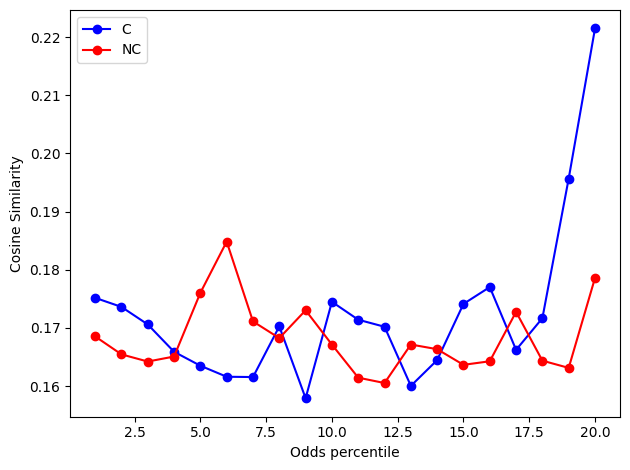

In [33]:
df_perplex_3 = df[df['perplexity']==3]

plt.plot(df_perplex_3['percentile'], df_perplex_3['cosine_similarities_C'], marker='o', label='C', color = 'blue')
plt.plot(df_perplex_3['percentile'], df_perplex_3['cosine_similarities_NC'], marker='o', label='NC', color='red')
plt.legend()

plt.xlabel('Odds percentile')
plt.ylabel('Cosine Similarity')
plt.tight_layout()

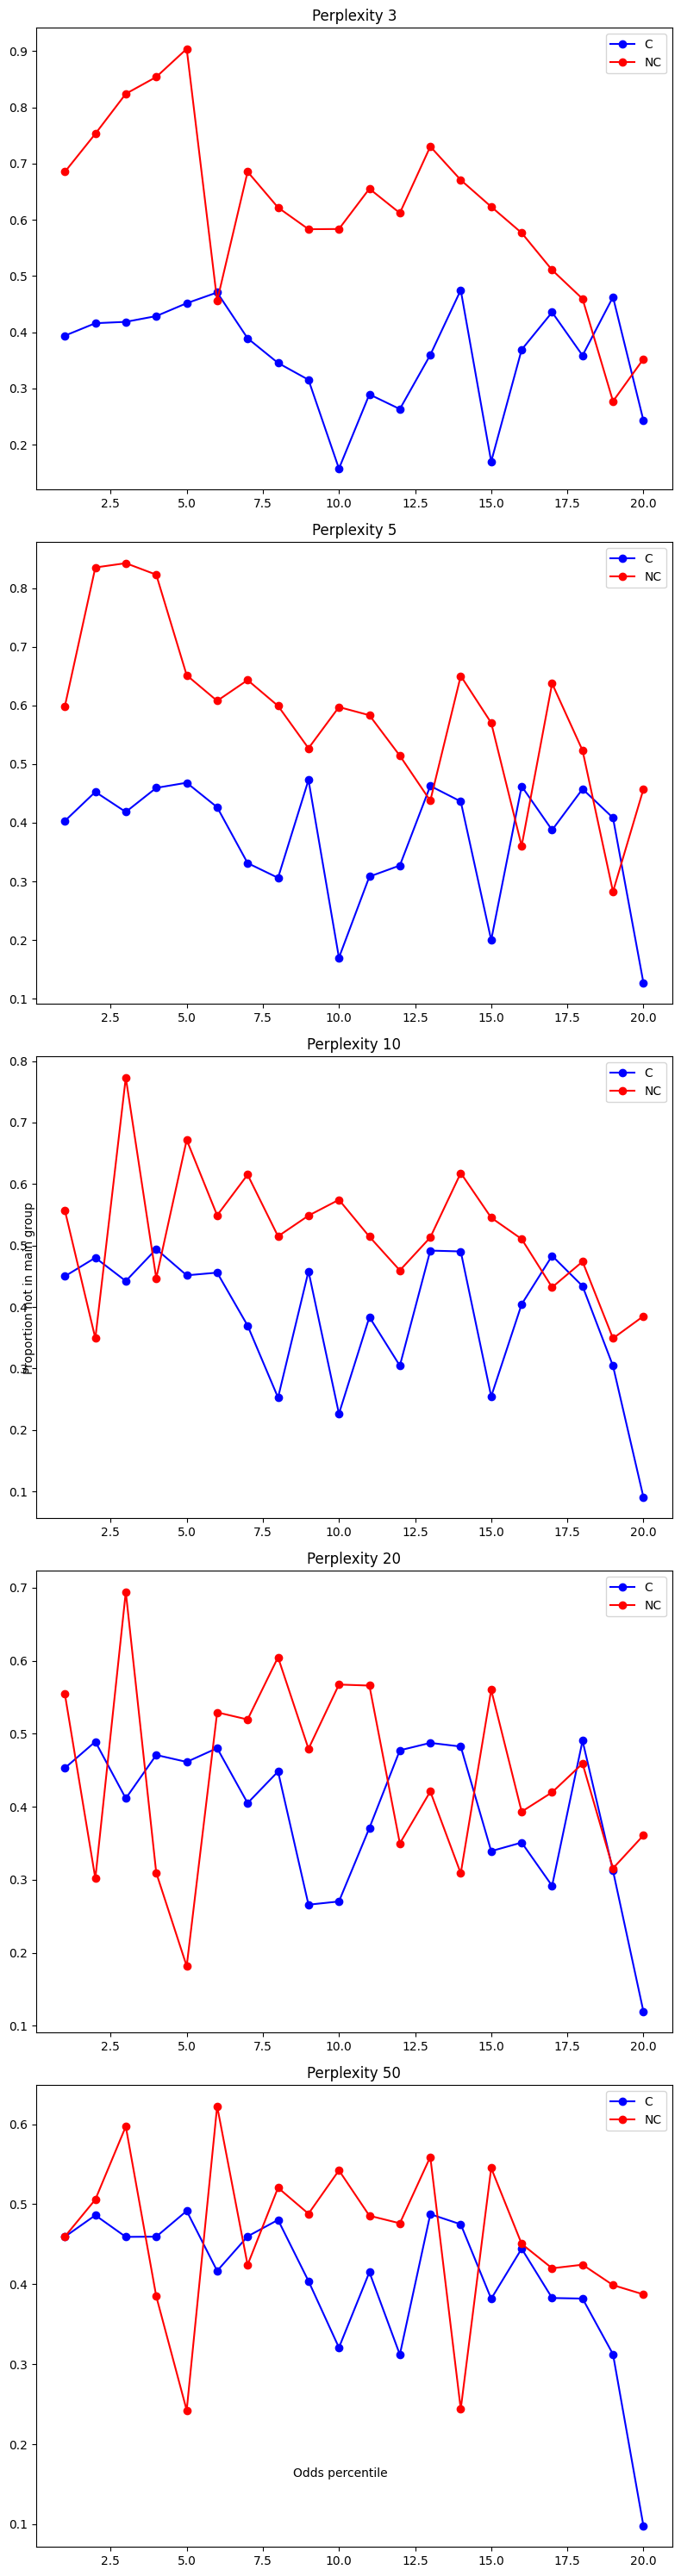

In [34]:
perplexities = df['perplexity'].unique()
fig, axes = plt.subplots(nrows=len(perplexities), ncols=1, figsize=(8, 6 * len(perplexities)))

# Plot data for each perplexity
for i, perplexity in enumerate(perplexities):
    subset = df[df['perplexity'] == perplexity]
    ax = axes[i]
    ax.plot(subset['percentile'], subset['prop_c_not_in_group_c'], marker='o', label='C', color = 'blue')
    ax.plot(subset['percentile'], subset['prop_nc_not_in_group_nc'], marker='o', label='NC', color='red')
    ax.set_title(f'Perplexity {perplexity}')
    ax.legend()

# Add common x and y axis labels
fig.text(0.5, 0.04, 'Odds percentile', ha='center')
fig.text(0.04, 0.5, 'Proportion not in main group', va='center', rotation='vertical')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

### Choose odds percentile 19+20 and perplexity ????

In [39]:
from adjustText import adjust_text
def plot_k_means_C(df):
    plt.figure(figsize=(16, 12))
    df = df[df['label']=='C']
    df['label_numeric'] = pd.Categorical(df['classification']).codes
    colors = ['b', 'c', 'y', 'm']
    scatter_TP = plt.scatter(x=df[df['classification']=='TP']['embedded_data1'], y=df[df['classification']=='TP']['embedded_data2'], marker='o', color=colors[0], s = 4)
    scatter_FN = plt.scatter(x=df[df['classification']=='FN']['embedded_data1'], y=df[df['classification']=='FN']['embedded_data2'], marker='x', color=colors[3], s = 4)
    
    texts = [plt.text(row['embedded_data1'], row['embedded_data2'], row['word_lemma'], fontsize=6, ha='right') for i, row in df.iterrows()]

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=0.5, force_points=0.5)
    
    plt.legend((scatter_TP, scatter_FN),
           ('True positive', 'False negative'),
           loc='upper right',
           fontsize=12)
    
    plt.savefig('plotC.svg', format='svg')

    plt.show()
    
def plot_k_means_NC(df):
    plt.figure(figsize=(16, 12))
    df = df[df['label']=='NC']
    df['label_numeric'] = pd.Categorical(df['classification']).codes
    colors = ['b', 'c', 'y', 'm']
    scatter_TN = plt.scatter(x=df[df['classification']=='TN']['embedded_data1'], y=df[df['classification']=='TN']['embedded_data2'], marker='o', color=colors[2])
    scatter_FP = plt.scatter(x=df[df['classification']=='FP']['embedded_data1'], y=df[df['classification']=='FP']['embedded_data2'], marker='x', color=colors[3])
    texts = [plt.text(row['embedded_data1'], row['embedded_data2'], row['word_lemma'], fontsize=6, ha='right') for i, row in df.iterrows()]
    

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=0.5, force_points=0.5)
    
    plt.legend((scatter_TN, scatter_FP),
           ('True negative', 'False positive'),
           loc='upper right',
           fontsize=12)
    
    plt.savefig('plotNC.svg', format='svg')

    plt.show()

We only plot the lemmas

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

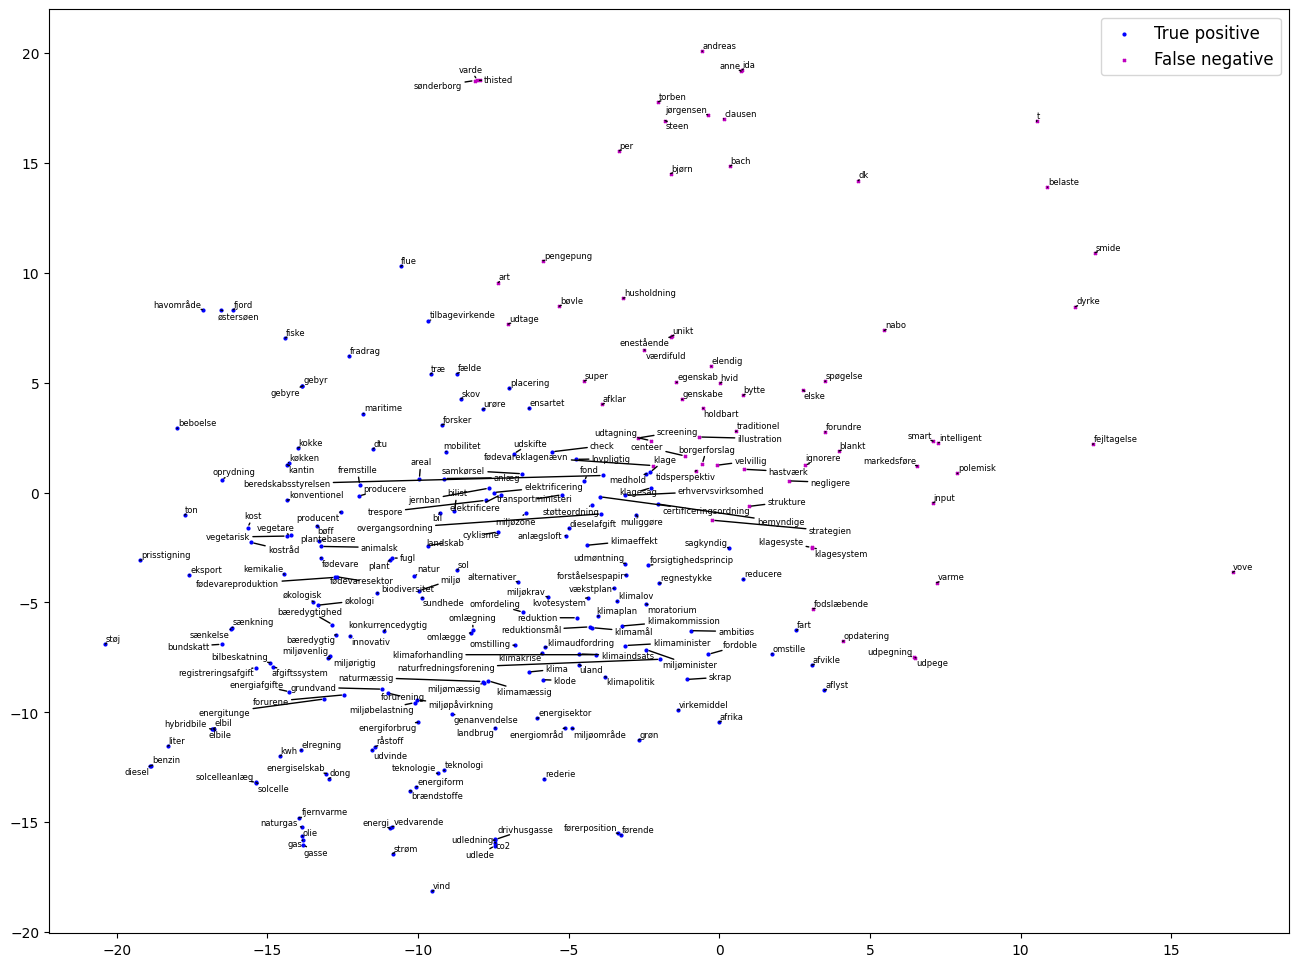

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\1743165590.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_numeric'] = pd.Categorical(df['classification']).codes


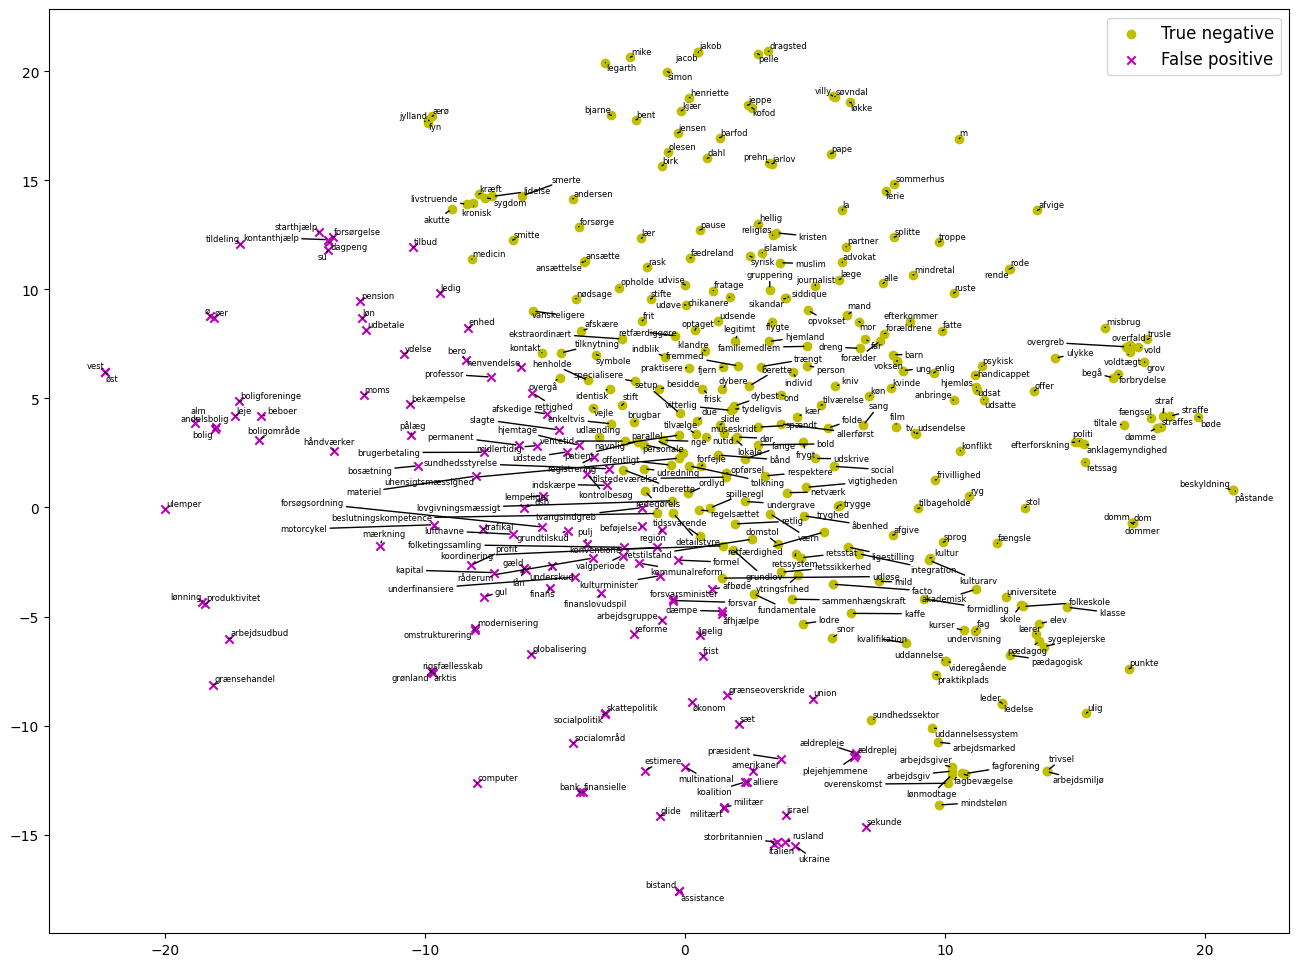

In [136]:
percentile_10 = pd.concat([choose_odds_percentiles(19), choose_odds_percentiles(20)])
percentile_10_lemmas = percentile_10.drop_duplicates(subset='word_lemma')
percentile_10_lemmas = k_means(percentile_10_lemmas, 'tsne', 2, perplex=20)
k_means_group_c = percentile_10_lemmas[percentile_10_lemmas['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
percentile_10_lemmas['k_means_group_tsne'] = np.where(percentile_10_lemmas['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')

percentile_10_lemmas['classification'] = np.where(
    (percentile_10_lemmas['label'] == 'C') & (percentile_10_lemmas['k_means_group_tsne'] == 'C'), 'TP',
    np.where((percentile_10_lemmas['label'] == 'NC') & (percentile_10_lemmas['k_means_group_tsne'] == 'NC'), 'TN',
             np.where((percentile_10_lemmas['label'] == 'C') & (percentile_10_lemmas['k_means_group_tsne'] == 'NC'), 'FN', 'FP')))

plot_k_means_C(percentile_10_lemmas)
plot_k_means_NC(percentile_10_lemmas)

In [137]:
percentile_10 = pd.concat([choose_odds_percentiles(19), choose_odds_percentiles(20)])
percentile_10= k_means(percentile_10, 'tsne', 2, perplex=20)
k_means_group_c = percentile_10[percentile_10['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
percentile_10['k_means_group_tsne'] = np.where(percentile_10['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')

percentile_10['classification'] = np.where(
    (percentile_10['label'] == 'C') & (percentile_10['k_means_group_tsne'] == 'C'), 'TP',
    np.where((percentile_10['label'] == 'NC') & (percentile_10['k_means_group_tsne'] == 'NC'), 'TN',
             np.where((percentile_10['label'] == 'C') & (percentile_10['k_means_group_tsne'] == 'NC'), 'FN', 'FP')))

C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_words_C_percentile["word_vec_dsl"] = unique_words_C_percentile.apply(lambda row: word_to_vec_dsl(row['word'], row['word_lemma']), axis=1)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\540236384.py:3: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  return model.word_vec(word)
C:\Users\ah140\AppData\Local\Temp\ipykernel_15216\4003398952.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [138]:
percentile_10['label'].value_counts()

label
NC    818
C     516
Name: count, dtype: int64

In [139]:
percentile_10['classification'].value_counts()

classification
TN    467
TP    425
FP    351
FN     91
Name: count, dtype: int64

We save the initial list of words and look at them manually

In [140]:
C_word_list = percentile_10[percentile_10['classification']=='TP']['word'].to_list()
with open('CTP_word_list.txt', 'w') as file:
    for item in C_word_list:
        file.write(f"{item}\n")

In [141]:
C_word_list = percentile_10[percentile_10['classification']=='FN']['word'].to_list()
with open('CNF_word_list.txt', 'w') as file:
    for item in C_word_list:
        file.write(f"{item}\n")

#### Final list of words

In [144]:
C_word_list = []
with open('data/Cwords_list.txt', 'r') as file:
    for item in file:
        C_word_list.append(item)